## Imports & loading the row training data + test data
---

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

yamen_mac_data_folder_path = '/Users/yamenalkattab/Desktop/guthub/ieee-fraud-detection'
yamen_data_folder_path = r'C:\Users\yamen\OneDrive\Desktop\DA151X KEX-arbete for DATA\kaggle\ieee-fraud-detection'
oscar_data_folder_path = r''

data_folder_path = yamen_data_folder_path

df_train_transaction = pd.read_csv(data_folder_path + '/train_transaction.csv')
#df_train_identity = pd.read_csv(your_data_folder_path + r'\train_identity.csv)

df_test_transaction = pd.read_csv(data_folder_path + '/test_transaction.csv')
#df_test_identity = pd.read_csv(your_data_folder_path + r'\test_identity.csv')

## data preprocessing functions
---

In [10]:
# pass in the data frame as an argument to change all boolean columns to binary with type int8 to occupy less memory
def encode_binary(df: pd.DataFrame, column_name):
    # Encode binary features T/F/NaN as 1/0/-1
    df[column_name] = df[column_name].map(lambda x: 1 if x=='T' else 0 if x=='F' else -1).astype('int8')
    return df[column_name]

# A pivvot table to be used in the object encoding functions. Diverse object columns EDA
def make_pivot(df:pd.DataFrame, index:str) -> pd.DataFrame:
    """..."""
    df[index] = df[index].fillna('NaN')
    df_pivot = df.pivot_table(index=index, columns='isFraud', aggfunc='size')
    df_pivot = df_pivot.fillna(0)
    df_pivot.columns = ['valid', 'fraud']
    df_pivot['count'] = df_pivot['valid'] + df_pivot['fraud']
    df_pivot[['valid_norm', 'fraud_norm']] = df_pivot[['valid', 'fraud']].div(other=df_pivot['count'], axis=0)
    df_pivot = df_pivot.sort_values(by='fraud_norm', ascending=False)
    return df_pivot

# works for columns with objects to be encoded as numerical (procudctCD, card4, card6, M4, P_emaildomain, R_emaildomain)
# NOT USED IN THE MAIN FUNCTION, due to test dataset doesnt have the "isFraud" column
def encode_hierercical_fraud_rate(df: pd.DataFrame, column_name:str):
    temp_pivot = make_pivot(df, index=column_name)
    return df[column_name].map(temp_pivot['fraud_norm'])


""" partition fraud rates into degree of risks
<1%           low risk 0
>=1% & <5% medium risk 1
>=5%         high risk 2
NaNs       medium risk 1 """

def encode_risk_group(df:pd.DataFrame, column_name:str):
    return df[column_name].transform(lambda x: 0 if x<0.01 else 1 if 0.01<=x<0.05 else 2 if 0.05<=x else np.NaN)


# the main function to preprocess the whole two (train AND test) dataset. Takes in the training dataset as FIRST argument and the testing dataset as the SECOND argument
def preprocess_dataset(df_train:pd.DataFrame, df_test:pd.DataFrame):
    # 1. make tranasactionID to be the index
    df_train = df_train.set_index('TransactionID'); df_test = df_test.set_index('TransactionID')

    # 2. preprocessing columns with binary values
    binary_object_columns = ['M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9'] # M1-M3, M5-M9, encode as 0/1 for False/True
    for col in binary_object_columns:
        df_train[col] = encode_binary(df_train, col)
        df_test[col] = encode_binary(df_test, col)

    # 3. preprocessing columns with diverse object values
    diverse_object_columns = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M4']
    for col in diverse_object_columns:
        temp_pivot = make_pivot(df_train, index=col) #make pivot using the trianing dataset, but the encoding is done on both datasets
        df_train[col] = df_train[col].map(temp_pivot['fraud_norm'])
        df_test[col] = df_test[col].map(temp_pivot['fraud_norm'])

    # 4. preprocessing columns with risk groups
    encode_risk_group_column = ['P_emaildomain', 'R_emaildomain']
    for col in encode_risk_group_column:
        df_train[col] = encode_risk_group(df_train, col)
        df_test[col] = encode_risk_group(df_test, col)
    # remove P_emaildomain and R_emaildomain from the dataframe
    df_train = df_train.drop(columns=['P_emaildomain', 'R_emaildomain'])
    df_test = df_test.drop(columns=['P_emaildomain', 'R_emaildomain'])

    # 5. features to be taken out of the dataset due to high correlaiton with other features (logic code is in Oscar's branch)
    redundent_features = ['C1', 'C2', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C14', 'M2', 'M3', 'M7', 'M9', 'D1', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V14', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V57', 'V58', 'V59', 'V60', 'V63', 'V64', 'V65', 'V68', 'V69', 'V71', 'V72', 'V73', 'V95', 'V96', 'V97', 'V101', 'V102', 'V103', 'V105', 'V106', 'V126', 'V127', 'V128', 'V132', 'V133', 'V134', 'V141', 'V142', 'V143', 'V144', 'V145', 'V148', 'V149', 'V150', 'V151', 'V153', 'V154', 'V155', 'V156', 'V157', 'V158', 'V159', 'V160', 'V164', 'V167', 'V168', 'V177', 'V178', 'V179', 'V182', 'V202', 'V203', 'V204', 'V211', 'V212', 'V213', 'V217', 'V218', 'V219', 'V231', 'V232', 'V233', 'V273', 'V275', 'V279', 'V280', 'V293', 'V294', 'V295', 'V296', 'V298', 'V299', 'V306', 'V307', 'V308', 'V316', 'V317', 'V318', 'V322', 'V323', 'V324', 'V329', 'V330', 'V331', 'V332', 'V333', 'V334']
    df_train = df_train.drop(redundent_features, axis=1)
    df_test = df_test.drop(redundent_features, axis=1)

    print (f'Preprocessing is done. The training dataset has {df_train.shape[0]} rows and {df_train.shape[1]} columns')
    print (f'The testing dataset has {df_test.shape[0]} rows and {df_test.shape[1]} columns')
    #check for missing values
    print('Missing values in the training dataset:', df_train.isnull().sum().sum())
    print('Missing values in the testing dataset:', df_test.isnull().sum().sum())
    
    return df_train, df_test


## visulalizing functions & settings
---

In [6]:
# Define ANSI escape codes for colors
color_red = '\033[31m'
color_green = '\033[32m'
color_yellow = '\033[33m'
color_blue = '\033[34m'
color_magenta = '\033[35m'
color_cyan = '\033[36m'
color_reset = '\033[0m'  # Reset color to default

pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', None)
#df_train_transaction.describe()

def describe_whole_df(df):
    for col in df.columns:
        values = df_train_transaction[col]
        num_uniques = values.nunique()
        
        # Data type of the column
        data_type = values.dtype
        
        # Number of NaN values
        num_nan = values.isnull().sum()
        
        # Number of non-NaN values
        num_non_nan = values.count()
        
        # Ratio of NaN values
        if num_non_nan > 0:
            nan_ratio = num_nan / (num_nan + num_non_nan)
        else:
            nan_ratio = np.nan
        
        print(color_cyan + f'Column: {col}' + color_reset)
        print(color_yellow + f'Data Type: {data_type}'+ color_reset)
        print(color_magenta+ f'Number of Unique Values: {num_uniques}'+ color_reset)
        print(color_red+ f'Number of NaN Values: {num_nan}'+ color_reset)
        print(color_green+ f'Number of Non-NaN Values: {num_non_nan}'+ color_reset)
        print(color_blue+ f'Ratio of NaN Values: {nan_ratio:.4f}\n'+ color_reset)
        
        print(f'Unique Values:')
        print(values.unique())
        
        # Plotting example (optional)
        if num_uniques <= 10:  # Plot only if number of unique values is reasonable
            plt.figure(figsize=(8, 4))
            if pd.api.types.is_numeric_dtype(values):
                sns.histplot(values.dropna(), bins=20, kde=True)
                plt.title(f'Histogram of {col}')
                plt.xlabel(col)
                plt.ylabel('Frequency')
            else:
                value_counts = values.value_counts()
                sns.barplot(x=value_counts.index, y=value_counts.values)
                plt.title(f'Bar plot of {col}')
                plt.xlabel(col)
                plt.ylabel('Count')
                plt.xticks(rotation=45)
            plt.show()
        print('\n --------------------------------------------NEXT FEATURE---------------------------------------------\n')

def describe_df_with_columns(df,list_of_columns):
    for col in list_of_columns:
        values = df[col]
        num_uniques = values.nunique()
        if num_uniques <= 2:
            continue
        data_type = values.dtype
        num_nan = values.isnull().sum()
        num_non_nan = values.count()
        if num_non_nan > 0:
            nan_ratio = num_nan / (num_nan + num_non_nan)
        else:
            nan_ratio = np.nan
        print(color_cyan + f'Column: {col}' + color_reset)
        print(color_yellow + f'Data Type: {data_type}'+ color_reset)
        print(color_magenta+ f'Number of Unique Values: {num_uniques}'+ color_reset)
        print(color_red+ f'Number of NaN Values: {num_nan}'+ color_reset)
        print(color_green+ f'Number of Non-NaN Values: {num_non_nan}'+ color_reset)
        print(color_blue+ f'Ratio of NaN Values: {nan_ratio:.4f}\n'+ color_reset)
        print(f'Unique Values:')
        print(values.unique())
        if num_uniques <= 10:  # Plot only if number of unique values is reasonable
            plt.figure(figsize=(8, 4))
            if pd.api.types.is_numeric_dtype(values):
                sns.histplot(values.dropna(), bins=100, kde=True)
                plt.title(f'Histogram of {col}')
                plt.xlabel(col)
                plt.ylabel('Frequency')
            else:
                value_counts = values.value_counts()
                sns.barplot(x=value_counts.index, y=value_counts.values)
                plt.title(f'Bar plot of {col}')
                plt.xlabel(col)
                plt.ylabel('Count')
                plt.xticks(rotation=45)
            plt.show()
        print('\n --------------------------------------------NEXT FEATURE---------------------------------------------\n')

## make a copy of original data sets & preprocess them
--- 

In [11]:
df_train_transaction_pp = df_train_transaction.copy()
df_test_transaction_pp = df_test_transaction.copy()

df_test_transaction_pp = preprocess_dataset(df_train_transaction_pp,df_test_transaction_pp)






Preprocessing is done. The training dataset has 590540 rows and 272 columns
The testing dataset has 506691 rows and 271 columns
Missing values in the training dataset: 65411845
Missing values in the testing dataset: 50372081


TEMP (you can test below here. Dont delete anything above this cell)
--

In [ ]:
df_categorical = df_train_transaction.select_dtypes(include=[object])



describe_df_with_columns(df_train_transaction_pp,diverse_object_columns)


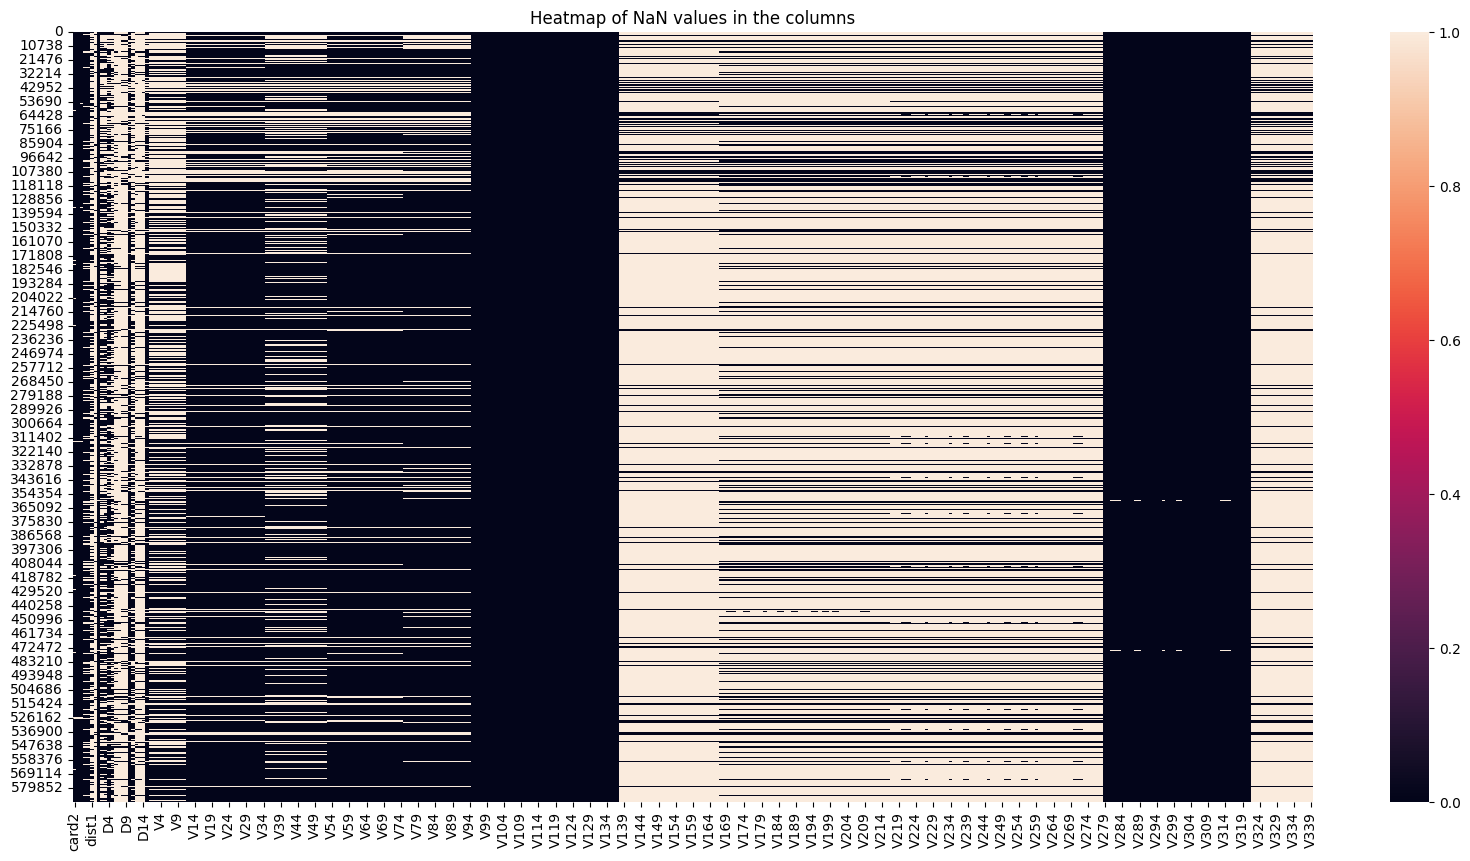

In [ ]:
# make a list of columns with NaN values
columns_nan = df_train_transaction_pp.columns[df_train_transaction_pp.isna().any()].tolist()
# make a heatmap of the columns with NaN values with maximum size
plt.figure(figsize=(20, 10))
sns.heatmap(data=df_train_transaction_pp[columns_nan].isna(), cbar=True)
plt.show()

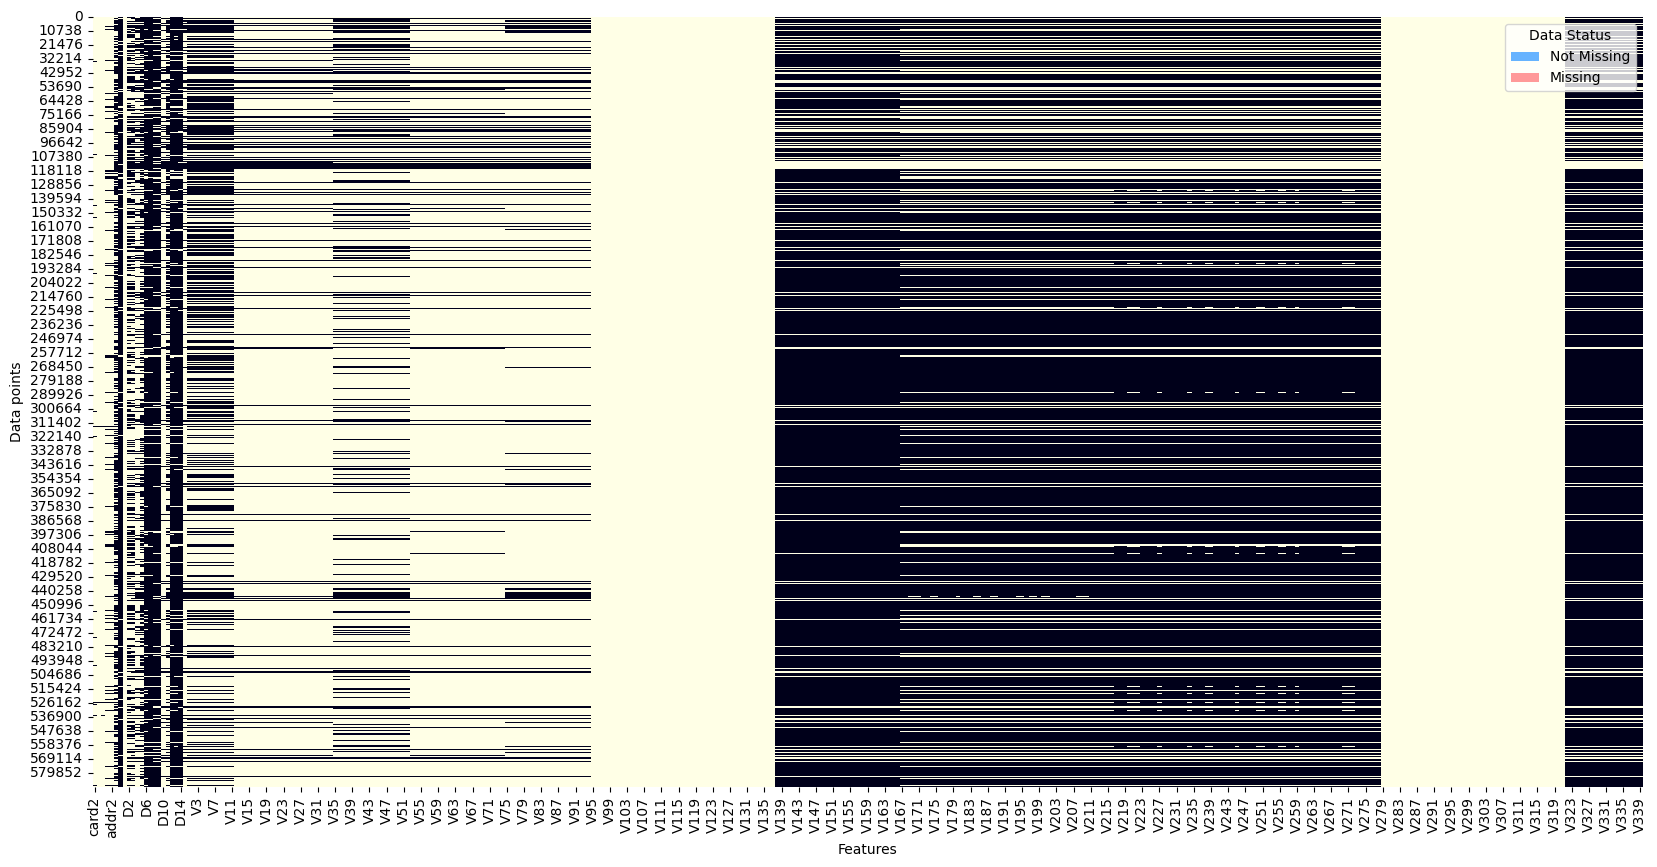

In [ ]:
# a smaller version of the heatmap with only the first 10 features to show in the article
columns_nan = df_train_transaction_pp.columns[df_train_transaction_pp.isna().any()].tolist()

plt.figure(figsize=(20, 10))
heatmap = sns.heatmap(data=df_train_transaction_pp[columns_nan].isna(), cbar=False, cmap=sns.color_palette(["#ffffe6", "#00001a"]))
#add the axis labels and a legend
plt.xlabel('Features')
plt.ylabel('Data points')

from matplotlib.patches import Patch
legend_handles = [Patch(facecolor="#ffffe6", label='Not Missing'),
                  Patch(facecolor="#00001a", label='Missing')]
plt.legend(handles=legend_handles, loc='upper right', title='Data Status')

plt.show()
#plt.title('Heatmap of NaN values in the columns')